### Compare theoretical and ground state energy at unit filling

In [192]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps
import importlib
from random import shuffle
importlib.reload(pimc)

<module 'pimc' from '/Users/ecasiano/Desktop/LatticePIMC/src/pimc.py'>

### Simulation parameters

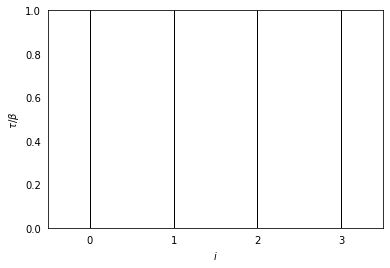

In [193]:
importlib.reload(pimc)
# Simulation parameters
t = 1.0
U = 5.0 # eta = 0.09, mu = 0
mu = U/2
L = 4
N = 4

# PIMC parameters
beta = 1.0
eta = 1/np.sqrt(L*beta) # Z_frac = 17.50%
eta = 0.25
eta = 0.09
dtau = 0.4999*beta # Set neighborhood of beta/2 where <K> will be measured

# Canonical or Grand Canonical?
canonical = True # False means Grand Canonical
N_check = [N] # Tracks the total number of particle to enforce Canonical simulations

# Create a random worldline configuration
alpha = pimc.random_boson_config(L,N)
alpha = [1]*L
data_struct = pimc.create_data_struct(alpha,L)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many iterations of the set of PIMC-WA updates

In [194]:
importlib.reload(pimc)

# Create the data structure
data_struct = pimc.create_data_struct(alpha,L)
head_loc = []
tail_loc = []

# Store values of observables
Z_ctr = 0 # Count configurations with no worm ends
diagonal_list = []
kinetic_list = []
N_list = [] # average total particles 
occ_list = [] # average particle occupation
E_N_list = [] # Fixed total particle energies
E_canonical_list = [] # To save energies only for N space configurations

# Counters for acceptance of each move
insert_worm_data = [0,0] # [accepted,proposed]
delete_worm_data = [0,0]

insert_anti_data = [0,0]
delete_anti_data = [0,0]

advance_head_data = [0,0]
recede_head_data = [0,0]

advance_tail_data = [0,0]
recede_tail_data = [0,0]

insertZero_worm_data = [0,0]
deleteZero_worm_data = [0,0]

insertZero_anti_data = [0,0]
deleteZero_anti_data = [0,0]

insertBeta_worm_data = [0,0]
deleteBeta_worm_data = [0,0]

insertBeta_anti_data = [0,0]
deleteBeta_anti_data = [0,0]

ikbh_data = [0,0]
dkbh_data = [0,0]

ikah_data = [0,0]
dkah_data = [0,0]

ikbt_data = [0,0]
dkbt_data = [0,0]

ikat_data = [0,0]
dkat_data = [0,0]

In [195]:
%%time

# Set the number of times the set of updates will be attempted
mc_steps = int(5.0E+06)
for m in range(mc_steps):
    
    # assign a label to each update
    labels = list(range(15)) # There 15 functions
    shuffle(labels)
    
    # At every mc step, try EVERY update in random order
    for label in labels:   
        
        # Non-Spaceshift moves
        if label == 0:
            result = pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,N_check,insert_worm_data,insert_anti_data)

        elif label == 1:
            result = pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,N_check,delete_worm_data,delete_anti_data)

        elif label == 2:
            result = pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,L,N,canonical,N_check,advance_head_data,recede_head_data,advance_tail_data,recede_tail_data)

        elif label == 3:
            result = pimc.insertZero(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,N_check,insertZero_worm_data,insertZero_anti_data)

        elif label == 4:
            result = pimc.deleteZero(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,N_check,deleteZero_worm_data,deleteZero_anti_data)

        elif label == 5:
            result = pimc.insertBeta(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,N_check,insertBeta_worm_data,insertBeta_anti_data)

        elif label == 6:
            result = pimc.deleteBeta(data_struct,beta,head_loc,tail_loc,U,mu,eta,L,N,canonical,N_check,deleteBeta_worm_data,deleteBeta_anti_data)

        # Spaceshift moves   
        elif label == 7:
            result = pimc.insert_kink_before_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,N_check,ikbh_data)  

        elif label == 8:
            result = pimc.delete_kink_before_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,N_check,dkbh_data) 

        elif label == 9:
            result = pimc.insert_kink_after_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,N_check,ikah_data)   

        elif label == 10:
            result = pimc.delete_kink_after_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,N_check,dkah_data)

        elif label == 11:
            result = pimc.insert_kink_before_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,N_check,ikbt_data)  

        elif label == 12:
            result = pimc.delete_kink_before_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,N_check,dkbt_data) 

        elif label == 13:
            result = pimc.insert_kink_after_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,N_check,ikat_data)   

        else:
            result = pimc.delete_kink_after_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,L,N,canonical,N_check,dkat_data)
      
    # print(N_check)   
    # Calculate observables when there are no worms present
    if m%L==0: # Ignore unequilibrated data
        
        if not(pimc.check_worm(head_loc,tail_loc)):
            
            # Count diagonal configurations
            Z_ctr += 1
            
            # Calculate kinetic, diagonal, and total energy
            if canonical:
                N_current = int(round(N_check[0],12))  # Round is used to fix precision errors in 16th bit
                if N_current == N:  # Round is used to fix precision errors in 16th bit
                    kinetic,diagonal = pimc.bh_egs(data_struct,beta,dtau,U,mu,t,L)
                    diagonal_list.append(diagonal+mu*N)
                    kinetic_list.append(kinetic)
            else:
                    kinetic,diagonal = pimc.bh_egs(data_struct,beta,dtau,U,mu,t,L)
                    diagonal_list.append(diagonal)
                    kinetic_list.append(kinetic)               
            
#             # Build histogram of fixed total particle energies E_N
#             N_current = int(round(N_check[0],8))  # Round is used to fix precision errors in 16th bit
#             E_current = kinetic+diagonal # total energy at this iteration
#             if canonical:
#                 if N_current == N:
#                     E_N_list.append((E_current,N_current))
#             else: # Grand canonical 
#                 E_N_list.append((E_current,N_current))


            # Calculate the average total number of particles
            N_list.append(pimc.n_pimc(data_struct,beta,L)) # <n>
            
            # Calculate the average particle occupation
            occ_list.append(pimc.n_i_pimc(data_struct,beta,L))          
            

CPU times: user 7min 55s, sys: 2.67 s, total: 7min 58s
Wall time: 7min 58s


In [196]:
# Acceptance ratios
print("\n-------- Acceptance Ratios --------\n")

print("       Insert worm: (%d/%d)"%(insert_worm_data[0],insert_worm_data[1]))
print("       Delete worm: (%d/%d)\n"%(delete_worm_data[0],delete_worm_data[1]))

print("       Insert anti: (%d/%d)"%(insert_anti_data[0],insert_anti_data[1]))
print("       Delete anti: (%d/%d)\n"%(delete_anti_data[0],delete_anti_data[1]))

print("       Advance head: (%d/%d)"%(advance_head_data[0],advance_head_data[1]))
print("        Recede head: (%d/%d)\n"%(recede_head_data[0],recede_head_data[1]))

print("       Advance tail: (%d/%d)"%(advance_tail_data[0],advance_tail_data[1]))
print("        Recede tail: (%d/%d)\n"%(recede_tail_data[0],recede_tail_data[1]))

print("   InsertZero worm: (%d/%d)"%(insertZero_worm_data[0],insertZero_worm_data[1]))
print("   DeleteZero worm: (%d/%d)\n"%(deleteZero_worm_data[0],deleteZero_worm_data[1]))

print("   InsertZero anti: (%d/%d)"%(insertZero_anti_data[0],insertZero_anti_data[1]))
print("   DeleteZero anti: (%d/%d)\n"%(deleteZero_anti_data[0],deleteZero_anti_data[1]))

print("   InsertBeta worm: (%d/%d)"%(insertBeta_worm_data[0],insertBeta_worm_data[1]))
print("   DeleteBeta worm: (%d/%d)\n"%(deleteBeta_worm_data[0],deleteBeta_worm_data[1]))

print("   InsertBeta anti: (%d/%d)"%(insertBeta_anti_data[0],insertBeta_anti_data[1]))
print("   DeleteBeta anti: (%d/%d)\n"%(deleteBeta_anti_data[0],deleteBeta_anti_data[1]))

print("              IKBH: (%d/%d)"%(ikbh_data[0],ikbh_data[1])) 
print("              DKBH: (%d/%d)\n"%(dkbh_data[0],dkbh_data[1]))

print("              IKAH: (%d/%d)"%(ikah_data[0],ikah_data[1])) 
print("              DKAH: (%d/%d)\n"%(dkah_data[0],dkah_data[1])) 

print("              IKBT: (%d/%d)"%(ikbt_data[0],ikbt_data[1])) 
print("              DKBT: (%d/%d)\n"%(dkbt_data[0],dkbt_data[1]))

print("              IKAT: (%d/%d)"%(ikat_data[0],ikat_data[1])) 
print("              DKAT: (%d/%d)\n"%(dkat_data[0],dkat_data[1])) 


-------- Acceptance Ratios --------

       Insert worm: (4688/1854265)
       Delete worm: (4793/5465)

       Insert anti: (10062/1853501)
       Delete anti: (11101/11119)

       Advance head: (325750/325750)
        Recede head: (323449/323449)

       Advance tail: (323473/323473)
        Recede tail: (325118/325118)

   InsertZero worm: (186517/2795574)
   DeleteZero worm: (185987/193761)

   InsertZero anti: (358484/2112848)
   DeleteZero anti: (357954/407978)

   InsertBeta worm: (185755/2800314)
   DeleteBeta worm: (185141/193020)

   InsertBeta anti: (357857/2107657)
   DeleteBeta anti: (357243/406924)

              IKBH: (329089/697721)
              DKBH: (327121/394279)

              IKAH: (186772/698547)
              DKAH: (188775/235580)

              IKBT: (186017/696981)
              DKBT: (188076/234992)

              IKAT: (328640/696377)
              DKAT: (326541/393264)



### Process data

N_check:  4.0
3.9999999999997398


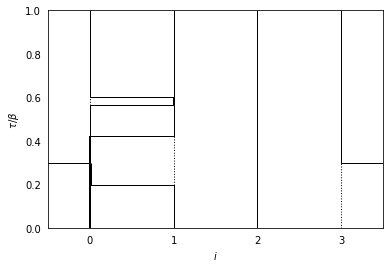

In [197]:
print("N_check: ",pimc.N_tracker(data_struct,beta,L))
print(N_check[0])
pimc.view_worldlines(data_struct,beta,figure_name=None)

In [198]:
# Set what values to ignore due to equilibration
mc_fraction = 0.5
start = int(len(diagonal_list)*0.10)
start = 25000

diagonal = np.mean(diagonal_list[start:])
kinetic = np.mean(kinetic_list[start:])
N_mean = np.mean(N_list[start:])
occ = np.mean(occ_list,axis=0)
print(Z_ctr)
print(len(diagonal_list))
print(len(diagonal_list)-start)


936949
330254
305254


In [199]:
importlib.reload(pimc)
if canonical:
    print("\nEnsemble: Canonical\n")
else:
    print("\nEnsemble: Grand Canonical")
print("-------- Ground State Energy (E/t) --------")
print("E/t: %.8f "%((diagonal+kinetic)/t))
print("-------- Average particle density --------")
print("<N>\L: %.8f"%(N_mean/L))
print("-------- Average occupation --------")
print("<n_i>:",occ)
print("-------- Z-configuration fraction --------")
print("Z-fraction: %.2f%% (%d/%d) "%(Z_ctr/mc_steps*100,Z_ctr,mc_steps))


Ensemble: Canonical

-------- Ground State Energy (E/t) --------
E/t: -2.58254599 
-------- Average particle density --------
<N>\L: 1.16456567
-------- Average occupation --------
<n_i>: [1.15990838 1.15816976 1.16511998 1.17550795]
-------- Z-configuration fraction --------
Z-fraction: 18.74% (936949/5000000) 


### Fixed total particle (E_N) energy histogram

In [200]:
# from collections import OrderedDict
# # reference: https://stackoverflow.com/a/51491688

# d = OrderedDict()
# for en,n in E_N_list: # en: energy, n: total particle number
#     d.setdefault(n, []).append(en)
    
# d = [(sum(v) / len(v), k) for k, v in d.items()]

# d = sorted(d,key=lambda x: x[1])

In [201]:
# print("\n-------- Average energy of fixed N sectors (E_N/t) --------")
# for i in range(len(d)):
#         print("E_%i/t: %.4f"%(d[i][1],d[i][0]/t))

In [202]:
Z_ctr

936949

### Save data

In [191]:
kinetic_list = np.array(kinetic_list)
with open("kinetic_%i_%i_%.4f_%.4f_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,t,eta,beta,mc_steps),"w+") as data:
    np.savetxt(data,kinetic_list,delimiter=",",fmt="%.16f",header="MC_step <E> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,t=%.4f,eta=%.8f,beta=%.4f,MC_steps=%i"%(L,N,U,mu,t,eta,beta,mc_steps))
    
diagonal_list = np.array(diagonal_list)
with open("diagonal_%i_%i_%.4f_%.4f_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,t,eta,beta,mc_steps),"w+") as data:
    np.savetxt(data,diagonal_list,delimiter=",",fmt="%.16f",header="MC_step <E> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,t=%.4f,eta=%.8f,beta=%.4f,MC_steps=%i"%(L,N,U,mu,t,eta,beta,mc_steps))
    
# n_list = np.array(n_list)
# with open("n_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
#     np.savetxt(data,n_list,delimiter=",",fmt="%.16f",header="MC_step <n> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
# occ_list = np.array(occ_list)
# with open("occ_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
#     np.savetxt(data,occ_list,delimiter=",",fmt="%.16f",header="MC_step <n_i> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))    

In [385]:
# Acceptance ratios
# print("\n-------- Acceptance Ratios --------\n")

# print("       Insert worm: %.4f%% (%d/%d)"%(100*insert_worm_data[0]/insert_worm_data[1],insert_worm_data[0],insert_worm_data[1]))
# print("       Delete worm: %.4f%% (%d/%d)\n"%(100*delete_worm_data[0]/delete_worm_data[1],delete_worm_data[0],delete_worm_data[1]))

# print("       Insert anti: %.4f%% (%d/%d)"%(100*insert_anti_data[0]/insert_anti_data[1],insert_anti_data[0],insert_anti_data[1]))
# print("       Delete anti: %.4f%% (%d/%d)\n"%(100*delete_anti_data[0]/delete_anti_data[1],delete_anti_data[0],delete_anti_data[1]))

# print("       Advance head: %.4f%% (%d/%d)"%(100*advance_head_data[0]/advance_head_data[1],advance_head_data[0],advance_head_data[1]))
# print("        Recede head: %.4f%% (%d/%d)\n"%(100*recede_head_data[0]/recede_head_data[1],recede_head_data[0],recede_head_data[1]))

# print("       Advance tail: %.4f%% (%d/%d)"%(100*advance_tail_data[0]/advance_tail_data[1],advance_tail_data[0],advance_tail_data[1]))
# print("        Recede tail: %.4f%% (%d/%d)\n"%(100*recede_tail_data[0]/recede_tail_data[1],recede_tail_data[0],recede_tail_data[1]))

# print("   InsertZero worm: %.4f%% (%d/%d)"%(100*insertZero_worm_data[0]/insertZero_worm_data[1],insertZero_worm_data[0],insertZero_worm_data[1]))
# print("   DeleteZero worm: %.4f%% (%d/%d)\n"%(100*deleteZero_worm_data[0]/deleteZero_worm_data[1],deleteZero_worm_data[0],deleteZero_worm_data[1]))

# print("   InsertZero anti: %.4f%% (%d/%d)"%(100*insertZero_anti_data[0]/insertZero_anti_data[1],insertZero_anti_data[0],insertZero_anti_data[1]))
# print("   DeleteZero anti: %.4f%% (%d/%d)\n"%(100*deleteZero_anti_data[0]/deleteZero_anti_data[1],deleteZero_anti_data[0],deleteZero_anti_data[1]))

# print("   InsertBeta worm: %.4f%% (%d/%d)"%(100*insertBeta_worm_data[0]/insertBeta_worm_data[1],insertBeta_worm_data[0],insertBeta_worm_data[1]))
# print("   DeleteBeta worm: %.4f%% (%d/%d)\n"%(100*deleteBeta_worm_data[0]/deleteBeta_worm_data[1],deleteBeta_worm_data[0],deleteBeta_worm_data[1]))

# print("   InsertBeta anti: %.4f%% (%d/%d)"%(100*insertBeta_anti_data[0]/insertBeta_anti_data[1],insertBeta_anti_data[0],insertBeta_anti_data[1]))
# print("   DeleteBeta anti: %.4f%% (%d/%d)\n"%(100*deleteBeta_anti_data[0]/deleteBeta_anti_data[1],deleteBeta_anti_data[0],deleteBeta_anti_data[1]))

# print("              IKBH: %.4f%% (%d/%d)"%(100*ikbh_data[0]/ikbh_data[1],ikbh_data[0],ikbh_data[1])) 
# print("              DKBH: %.4f%% (%d/%d)\n"%(100*dkbh_data[0]/dkbh_data[1],dkbh_data[0],dkbh_data[1]))

# print("              IKAH: %.4f%% (%d/%d)"%(100*ikah_data[0]/ikah_data[1],ikah_data[0],ikah_data[1])) 
# print("              DKAH: %.4f%% (%d/%d)\n"%(100*dkah_data[0]/dkah_data[1],dkah_data[0],dkah_data[1])) 

# print("              IKBT: %.4f%% (%d/%d)"%(100*ikbt_data[0]/ikbt_data[1],ikbt_data[0],ikbt_data[1])) 
# print("              DKBT: %.4f%% (%d/%d)\n"%(100*dkbt_data[0]/dkbt_data[1],dkbt_data[0],dkbt_data[1]))

# print("              IKAT: %.4f%% (%d/%d)"%(100*ikat_data[0]/ikat_data[1],ikat_data[0],ikat_data[1])) 
# print("              DKAT: %.4f%% (%d/%d)\n"%(100*dkat_data[0]/dkat_data[1],dkat_data[0],dkat_data[1])) 